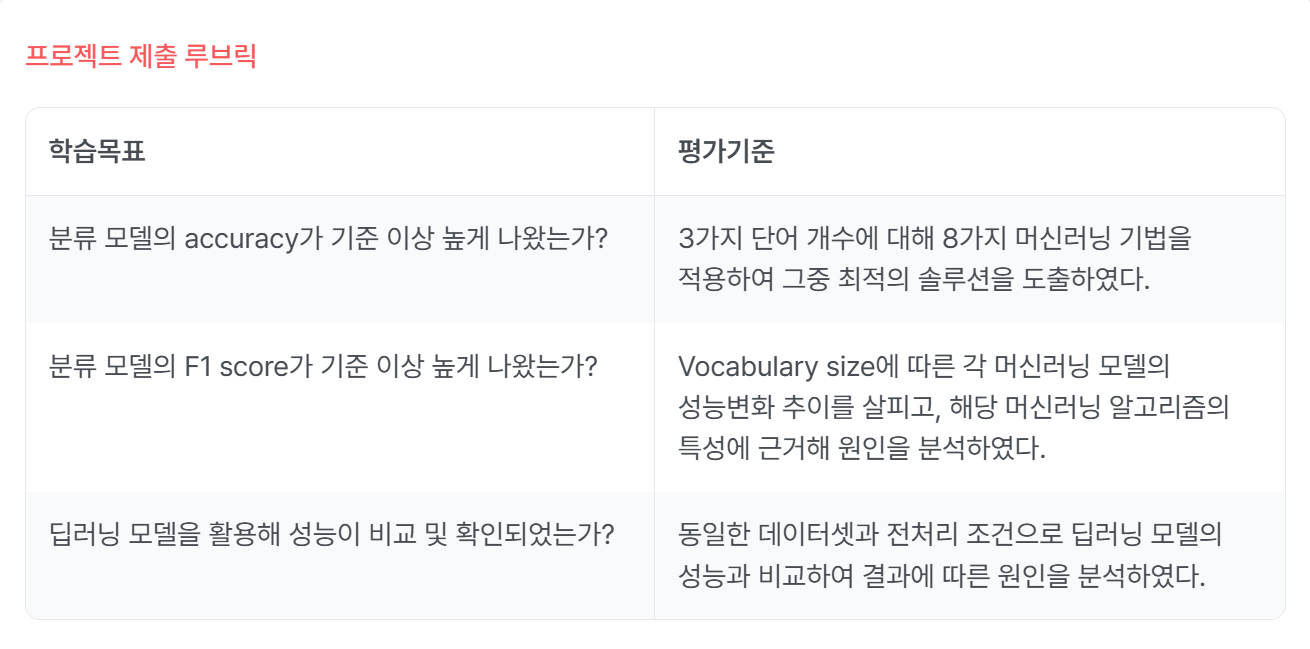

# **뉴스 카테고리 다중분류 프로젝트**

# **팀 전체가 시험한 모델**
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifie
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- 1-D CNN
- Voting model (LR+CNB)

# **추가 실험한 내용**
-1.일부 모델에서 보캡 사이즈에 따라 성능 변화가 나타나는데, 이를 더 체크하기 위해서 vocan size를 1000 ~ 30000으로 확대해 봄

   **--> 실험 결과: 적정 보캡 사이즈 구간을 넘어서면 유의미한 결과가 없는 실험으로 파악되었음.**

-2. 기존 hard voting(LR+CNB)를 확대하여, GradientBoosting를 제외한 8개 모델간의 soft voting 모델로 실험하였음 (소프트 voting 방식의 모델간 분류에 대한 이론적 배경 : 최종 분류 확률 예시 = (모델1 확률 + 모델2 확률 + 모델3 확률 + …) / N)

  **---> 실험 결과: 데이트 특성과 모델간 약점을 상호보완할 수 있는 잘 조합된 앙상블이면 상당히 안정적인 성능이 나올 수 있다. 모든 모델을 앙상블 하는 것은 효율적이거나 적절한 방법이 아닌듯 하다.**


# **팀 분석 결과**


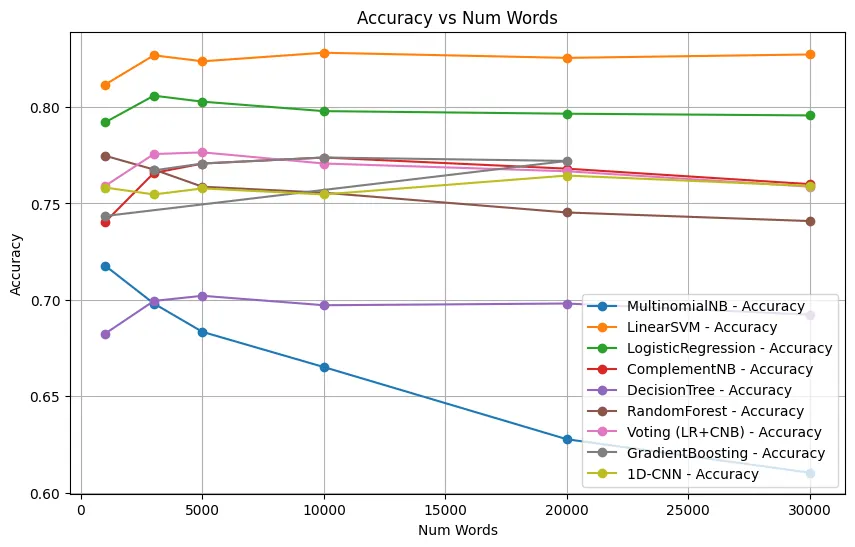

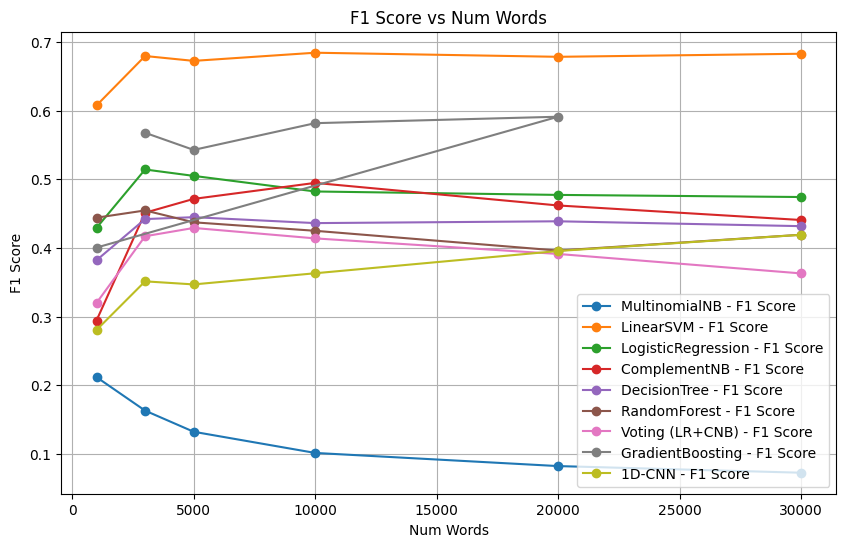


# **상기 결과를 반영한 추가 수정 실험 사항**
-적정 vocab size에 대한 분석이 사전적으로 논의될 필요 있음. 무작정 vocab size를 늘려서 실험하는 것은 시간과 비용의 낭비.
-적정 vocab size 분석 후, 실험 vocab size는 1000, 3000. 6000으로 설정함



# **코드 구성**

# 라이브러리 및 데이터 로드

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
import time
from tqdm import tqdm

# Sklearn(ML) 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# TensorFlow/Keras(DL) 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical


**주요 함수 구성 (soft voting 용 버전) **

모든 모델을 반영한 soft voting 모델을 구성해서 실험해봤으나, 성과가 좋지 않은  모델도 반영되게 됨에 따라 당연하게도 성능이 개션되지 않았음



In [ ]:
# ==================== SOFT VOTING 개선: 1-D CNN Sklearn Wrapper ==================== soft voting을 하기위하여 변경했더니 CNN Sklearn Wrapper가 등장했습니다. 뭔지 잘 몰라서 분석 요망
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Keras CNN 모델을 sklearn VotingClassifier와 호환되도록 만드는 래퍼"""
    def __init__(self, num_words, embedding_dim=128, maxlen=150,
                 epochs=5, batch_size=64, verbose=0, random_state=42):
        self.num_words = num_words
        self.embedding_dim = embedding_dim
        self.maxlen = maxlen
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.tokenizer = None
        self.num_classes_ = None
        self.classes_ = None

    def _create_model(self, num_classes):
        model = Sequential([
            Embedding(input_dim=self.num_words, output_dim=self.embedding_dim, input_length=self.maxlen),
            Dropout(0.3),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        if len(y.shape) == 1:
            self.num_classes_ = len(np.unique(y))
            self.classes_ = np.unique(y)
            y_cat = to_categorical(y, num_classes=self.num_classes_)
        else:
            self.num_classes_ = y.shape[1]
            self.classes_ = np.arange(self.num_classes_)
            y_cat = y

        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, padding='post', maxlen=self.maxlen)

        self.model = self._create_model(self.num_classes_)
        self.model.fit(X_pad, y_cat, epochs=self.epochs, batch_size=self.batch_size,
                      validation_split=0.1, verbose=self.verbose)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def predict_proba(self, X):
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, padding='post', maxlen=self.maxlen)
        return self.model.predict(X_pad, verbose=0)

print("✅ KerasClassifierWrapper 준비 완료")


✅ KerasClassifierWrapper 준비 완료


In [ ]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # num_words 일단 미지정

# word index 사전
word_index = reuters.get_word_index()

# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = {index + 3 : word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# 디코딩
def decode_review(encoded):
    return " ".join(index_to_word.get(i, "<unk>") for i in encoded)

train_texts_all = [decode_review(seq) for seq in x_train]
test_texts_all = [decode_review(seq) for seq in x_test]

# sample 확인
print(train_texts_all[:3])
print(test_texts_all[:3])

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 

In [ ]:
# 적정 vocab size 분석
from collections import Counter

# 함수 정의
def recommend_vocab_by_frequency(texts, percentile=90):
    all_words = []
    for text in texts:
        words = text.split()
        all_words.extend(words)

    word_freq = Counter(all_words)
    sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    total_words = sum(freq for _, freq in sorted_freq)
    cumsum = 0
    vocab_size = 0

    for word, freq in sorted_freq:
        cumsum += freq
        vocab_size += 1
        if cumsum / total_words >= percentile / 100:
            break

    print(f"📊 빈도 분석 기반 추천")
    print(f"   {percentile}% 단어 빈도 커버: {vocab_size:,} words")
    print(f"   누적 빈도: {cumsum:,} / {total_words:,} ({cumsum/total_words*100:.1f}%)")

    return vocab_size

# 실행
vocab_90 = recommend_vocab_by_frequency(train_texts_all, percentile=90)
vocab_95 = recommend_vocab_by_frequency(train_texts_all, percentile=95)
vocab_80 = recommend_vocab_by_frequency(train_texts_all, percentile=80)

# 결과
print("\n" + "="*50)
print("✅ 최종 추천:")
print(f"   80% 커버: {vocab_80:,} words")
print(f"   90% 커버: {vocab_90:,} words ⭐ (권장)")
print(f"   95% 커버: {vocab_95:,} words")
print("="*50)
```

시험할 Vocab size로 1000, 3000, 6000 으로 설정함

# 벡터화 & 모델 학습 및 평가

In [ ]:
# num_words 리스트
num_words_list = [1000, 3000, 6000]

# num_words별 학습 루프
results = []

for num_words in num_words_list:
    print(f"\n=== num_words = {num_words} ===")
    start_time = time.time()

    # num_words가 바뀔 때마다 정의해줘야 한다.
    vectorizer = TfidfVectorizer(max_features=num_words) # TF-IDF
    X_train = vectorizer.fit_transform(train_texts_all)
    X_test = vectorizer.transform(test_texts_all)

    # 모델 정의
    models = {
        "MultinomialNB": MultinomialNB(),
        "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=3),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, verbose=3)
    }

    # tqdm으로 모델 진행률 표시
    for model_name, model in tqdm(models.items(), desc="Training models"):
        model_start = time.time()  # 모델별 시작 시간
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro") # 다중분류 문제이므로 디폴트 binary에서 수정했다.

        results.append([num_words, model_name, acc, f1])

        model_time = time.time() - model_start
        print(f"{model_name:18s}  Acc = {acc:.4f},  F1 = {f1:.4f}  (Elapsed: {model_time:.1f}s)")

    loop_time = time.time() - start_time
    print(f"num_words = {num_words} loop finished in {loop_time:.1f}s")


=== num_words = 1000 ===


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.7097,  F1 = 0.1991  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:04<00:02,  2.14s/it]

LinearSVM           Acc = 0.8192,  F1 = 0.6159  (Elapsed: 4.2s)
      Iter       Train Loss   Remaining Time 
         1           1.5390           20.19m
         2       65614.6545           18.90m
         3       75172.7968           18.39m
         4      206658.1575           18.52m
         5 21356249879242766237380779340153749504.0000           18.14m
         6 59273427135773035272064109375767384686592.0000           17.81m
         7 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           17.53m
         8 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           17.22m
         9 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           16.95m
        10 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           16.76m
        11 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           16.55m
        12 9650499

Training models: 100%|██████████| 3/3 [18:19<00:00, 366.64s/it]

GradientBoosting    Acc = 0.7346,  F1 = 0.3915  (Elapsed: 1095.6s)
num_words = 1000 loop finished in 1103.4s

=== num_words = 3000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6915,  F1 = 0.1511  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LinearSVM           Acc = 0.8290,  F1 = 0.6818  (Elapsed: 2.6s)
      Iter       Train Loss   Remaining Time 
         1           1.4754           21.47m
         2     2170902.5562           21.25m
         3     2178222.9292           21.03m
         4 21474141373481801880539660292837384513152868921502682100460605685849575561088186503676484803401944091590656.0000           20.84m
         5 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.62m
         6 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.43m
         7 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.21m
         8 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.01m
         9 214741413846332049627948748405071522616

Training models: 100%|██████████| 3/3 [22:13<00:00, 444.55s/it]

GradientBoosting    Acc = 0.7671,  F1 = 0.5678  (Elapsed: 1331.0s)
num_words = 3000 loop finished in 1335.0s

=== num_words = 6000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6728,  F1 = 0.1068  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.79s/it]

LinearSVM           Acc = 0.8264,  F1 = 0.6792  (Elapsed: 3.5s)
      Iter       Train Loss   Remaining Time 
         1           1.4374           26.63m
         2       11202.4220           24.85m
         3    12737058.7819           24.54m
         4    45715560.9437           24.79m
         5 26730871691956338032640.0000           24.25m
         6 25053564686135602747756955205365700118469875531077364280111360996263990252366542667776.0000           23.88m
         7 25053564686135602747756955205365700118469875531077364280111360996263990252366542667776.0000           23.81m
         8 25053564686135602747756955205365700118469875531077364280111360996263990252366542667776.0000           23.64m
         9 25053564686135602747756955205365700118469875531077364280111360996263990252366542667776.0000           23.64m
        10 25053564686135602747756955205365700118469875531077364280111360996263990252366542667776.0000           23.24m
        11 250535646861356027477569552053657001184698

Training models: 100%|██████████| 3/3 [25:42<00:00, 514.12s/it]

GradientBoosting    Acc = 0.7698,  F1 = 0.5663  (Elapsed: 1538.8s)
num_words = 6000 loop finished in 1543.4s



===== 결과표 =====
   num_words             model  accuracy  f1_macro
0       1000     MultinomialNB  0.709706  0.199123
1       1000         LinearSVM  0.819234  0.615884
2       1000  GradientBoosting  0.734639  0.391456
3       3000     MultinomialNB  0.691451  0.151085
4       3000         LinearSVM  0.829029  0.681764
5       3000  GradientBoosting  0.767142  0.567806
6       6000     MultinomialNB  0.672752  0.106760
7       6000         LinearSVM  0.826358  0.679195
8       6000  GradientBoosting  0.769813  0.566332


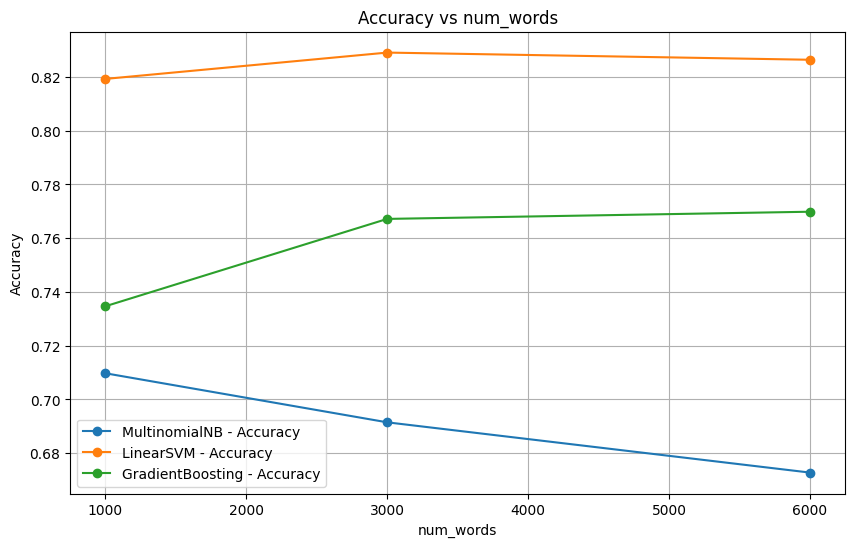

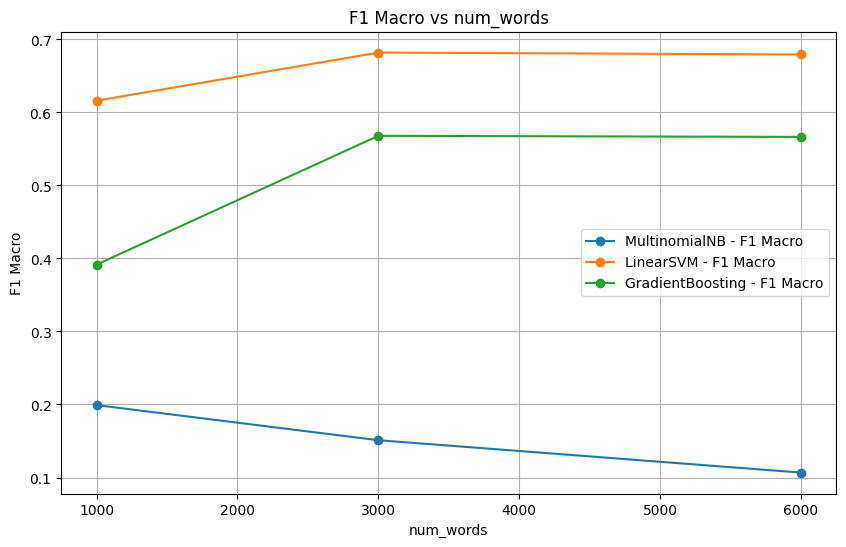

In [ ]:
# 결과 DataFrame 생성 + 시각화
df_results = pd.DataFrame(results, columns=["num_words", "model", "accuracy", "f1_macro"])
print("\n===== 결과표 =====")
print(df_results)

# 시각화
plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs num_words")
plt.xlabel("num_words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["f1_macro"], marker='o', label=f"{model_name} - F1 Macro")

plt.title("F1 Macro vs num_words")
plt.xlabel("num_words")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#df_results.to_csv("MNB_SVM_GBC.csv", index=False)

# 나머지 모델들 추가 분석

In [ ]:
# GPU 설정 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import time
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from sklearn.calibration import CalibratedClassifierCV # Import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier # Ensure VotingClassifier is imported if not already

# ... (rest of the imports and initial setup) ...

# num_classes는 reuters 데이터셋에서 46개입니다.
num_classes = 46

# ... (rest of the code) ...

# 하이퍼파라미터
EMBEDDING_DIM = 128
MAXLEN = 150
CNN_EPOCHS = 50 # epoch 수를 50으로 늘렸습니다.
CNN_BATCH_SIZE = 64


# --- 학습 루프 ---
for num_words in num_words_list:
    print(f"\n{'='*15} num_words = {num_words} {'='*15}")
    loop_start_time = time.time()

    print(f"[INFO] (A) Sklearn 모델 (TF-IDF, max_features={num_words}) 학습 시작...")

    # A-1. TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=num_words)
    X_train_tfidf = vectorizer.fit_transform(train_texts_all)
    X_test_tfidf = vectorizer.transform(test_texts_all)

    # A-2. Sklearn 모델 정의
    print("\n  ✓ 모델 초기화 중...")

    clf_mnb = MultinomialNB()
    clf_lsvm = LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=0)
    clf_lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
    clf_cnb = ComplementNB()
    clf_dt = DecisionTreeClassifier(random_state=42)
    clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0)

    # 1-D CNN 모델 (sklearn wrapper)
    clf_cnn = KerasClassifierWrapper(
        num_words=num_words,
        embedding_dim=EMBEDDING_DIM,
        maxlen=MAXLEN,
        epochs=CNN_EPOCHS,
        batch_size=CNN_BATCH_SIZE,
        verbose=0,
        random_state=42 # Add random_state for consistency
    )

    # A-3. 개별 모델들을 딥셔너리에 정의 (원본 목적: 개별 평가 및 학습)
    individual_models_for_eval = {
        "[1/7] MultinomialNB": clf_mnb,
        "[2/7] LinearSVM": clf_lsvm, # This is the original LinearSVC for individual eval
        "[3/7] LogisticRegression": clf_lr,
        "[4/7] ComplementNB": clf_cnb,
        "[5/7] DecisionTree": clf_dt,
        "[6/7] RandomForest": clf_rf,
        "[7/7] 1-D CNN": clf_cnn,
    }

    # A-4. 각 모델 학습 및 평가
    print("\n  ✒ 개별 모델 학습 시작...")
    for model_name, model in tqdm(individual_models_for_eval.items(), desc="  Training"):
        model_start = time.time()

        if model_name == "[7/7] 1-D CNN":
            model.fit(train_texts_all, y_train)
            preds = model.predict(test_texts_all)
        elif model_name in ["[5/7] DecisionTree", "[6/7] RandomForest"]:
            model.fit(X_train_tfidf.toarray(), y_train)
            preds = model.predict(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            preds = model.predict(X_test_tfidf)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        results.append([num_words, model_name, acc, f1])
        model_time = time.time() - model_start
        print(f"    {model_name:30s} | Acc: {acc:.4f} | F1: {f1:.4f} | Time: {model_time:.1f}s")


    # ========== B. SOFT VOTING 모델 (7개 모델 앙상블) ========== #
    print(f"\n[STEP B] SOFT VOTING 모델 학습 (7개 모델의 확률 평균)...")
    print(f"    구성: MultinomialNB + LinearSVM(Calibrated) + LogisticRegression + ComplementNB")
    print(f"           + DecisionTree + RandomForest + 1-D CNN")
    print(f"    방식: SOFT VOTING (각 모델의 예측 확률을 평균하여 최종 결정)")

    model_start = time.time()

    # CalibratedClassifierCV를 사용하여 LinearSVC의 predict_proba를 얻음
    # clf_lsvm은 A-2에서 이미 정의된 LinearSVC 인스턴스입니다.
    # LinearSVC를 먼저 학습시키난 후 CalibratedClassifierCV로 래핑합니다.
    clf_lsvm_calibrated = CalibratedClassifierCV(clf_lsvm, method='isotonic', cv='prefit')
    # clf_lsvm_calibrated.fit()은 X_train_tfidf를 사용해야 합니다.
    clf_lsvm_calibrated.fit(X_train_tfidf, y_train)

    # SOFT VOTING을 위한 모델 목록 (predict_proba 지원 모델만)
    soft_voting_models = {
        "[1/7] MultinomialNB": clf_mnb,
        "[2/7] LinearSVM (Calibrated)": clf_lsvm_calibrated, # Calibrated version
        "[3/7] LogisticRegression": clf_lr,
        "[4/7] ComplementNB": clf_cnb,
        "[5/7] DecisionTree": clf_dt,
        "[6/7] RandomForest": clf_rf,
        "[7/7] 1-D CNN": clf_cnn,
    }

    # 개별 모델의 predict_proba 결과를 저장할 리스트
    proba_list = []

    print("\n    SOFT VOTING 확률 예측 중...")
    for model_name, model in soft_voting_models.items():
        if "CNN" in model_name: # 1-D CNN은 predict_proba 호출 시 raw text 사용
            proba_list.append(model.predict_proba(test_texts_all))
        elif "DecisionTree" in model_name or "RandomForest" in model_name:
            # DecisionTree, RandomForest는 toarray() 필요
            proba_list.append(model.predict_proba(X_test_tfidf.toarray()))
        else:
            # 그 외 Sklearn 모델들은 sparse matrix 직접 사용
            proba_list.append(model.predict_proba(X_test_tfidf))

    # 확률 평균 계산
    avg_proba = np.mean(proba_list, axis=0)
    preds_voting = np.argmax(avg_proba, axis=1)

    # 성능 평가
    acc_voting = accuracy_score(y_test, preds_voting)
    f1_voting = f1_score(y_test, preds_voting, average="macro")

    results.append([num_words, "[8/8] ⭐ SOFT VOTING (Ensemble)", acc_voting, f1_voting])
    model_time = time.time() - model_start

    print(f"\n    SOFT VOTING 완료")
    print(f"     Accuracy: {acc_voting:.4f}")
    print(f"     F1 Score: {f1_voting:.4f}")
    print(f"     Time: {model_time:.1f}s")

    loop_time = time.time() - loop_start_time
    print(f"\n  num_words = {num_words} 완료 (  {loop_time:.1f}s)\n")

print("\n" + "="*100)
print("✅ 모든 실험 완료!")
print("="*100)

# --- 최종 결과 출력 ---
df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])
df_results = df_results.sort_values(by=["Num Words", "F1 Score"], ascending=[True, False])
print(df_results.to_string(index=False, float_format="%.4f"))


=============== num_words = 1000 ===============
[INFO] (A) Sklearn 모델 (TF-IDF, max_features=1000) 학습 시작...

  ✓ 모델 초기화 중...

  ✒ 개별 모델 학습 시작...


  Training:   0%|          | 0/7 [00:00<?, ?it/s]

    [1/7] MultinomialNB            | Acc: 0.7097 | F1: 0.1991 | Time: 0.0s


  Training:  29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]

    [2/7] LinearSVM                | Acc: 0.8192 | F1: 0.6159 | Time: 1.7s


  Training:  43%|████▎     | 3/7 [00:05<00:08,  2.18s/it]

    [3/7] LogisticRegression       | Acc: 0.7979 | F1: 0.4363 | Time: 4.0s
    [4/7] ComplementNB             | Acc: 0.7395 | F1: 0.2821 | Time: 0.0s


  Training:  71%|███████▏  | 5/7 [00:10<00:04,  2.29s/it]

    [5/7] DecisionTree             | Acc: 0.6923 | F1: 0.3931 | Time: 4.7s


  Training:  86%|████████▌ | 6/7 [00:18<00:03,  3.90s/it]

    [6/7] RandomForest             | Acc: 0.7738 | F1: 0.4532 | Time: 8.1s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
  Training: 100%|██████████| 7/7 [00:57<00:00,  8.23s/it]

    [7/7] 1-D CNN                  | Acc: 0.7498 | F1: 0.4734 | Time: 39.0s

[STEP B] SOFT VOTING 모델 학습 (7개 모델의 확률 평균)...
    구성: MultinomialNB + LinearSVM(Calibrated) + LogisticRegression + ComplementNB
           + DecisionTree + RandomForest + 1-D CNN
    방식: SOFT VOTING (각 모델의 예측 확률을 평균하여 최종 결정)

    SOFT VOTING 확률 예측 중...



/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



    SOFT VOTING 완료
     Accuracy: 0.8054
     F1 Score: 0.5393
     Time: 0.5s

  num_words = 1000 완료 (  59.1s)


=============== num_words = 3000 ===============
[INFO] (A) Sklearn 모델 (TF-IDF, max_features=3000) 학습 시작...

  ✓ 모델 초기화 중...

  ✒ 개별 모델 학습 시작...


  Training:   0%|          | 0/7 [00:00<?, ?it/s]

    [1/7] MultinomialNB            | Acc: 0.6915 | F1: 0.1511 | Time: 0.0s


  Training:  29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]

    [2/7] LinearSVM                | Acc: 0.8290 | F1: 0.6818 | Time: 2.1s


  Training:  43%|████▎     | 3/7 [00:07<00:11,  2.90s/it]

    [3/7] LogisticRegression       | Acc: 0.8019 | F1: 0.4808 | Time: 5.4s
    [4/7] ComplementNB             | Acc: 0.7631 | F1: 0.4187 | Time: 0.0s


  Training:  71%|███████▏  | 5/7 [00:16<00:07,  3.70s/it]

    [5/7] DecisionTree             | Acc: 0.6950 | F1: 0.4580 | Time: 8.7s


  Training:  86%|████████▌ | 6/7 [00:27<00:05,  5.82s/it]

    [6/7] RandomForest             | Acc: 0.7667 | F1: 0.4678 | Time: 11.3s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
  Training: 100%|██████████| 7/7 [01:07<00:00,  9.69s/it]

    [7/7] 1-D CNN                  | Acc: 0.7596 | F1: 0.5390 | Time: 40.2s

[STEP B] SOFT VOTING 모델 학습 (7개 모델의 확률 평균)...
    구성: MultinomialNB + LinearSVM(Calibrated) + LogisticRegression + ComplementNB
           + DecisionTree + RandomForest + 1-D CNN
    방식: SOFT VOTING (각 모델의 예측 확률을 평균하여 최종 결정)

    SOFT VOTING 확률 예측 중...



/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



    SOFT VOTING 완료
     Accuracy: 0.8139
     F1 Score: 0.6075
     Time: 0.7s

  num_words = 3000 완료 (  69.4s)


=============== num_words = 6000 ===============
[INFO] (A) Sklearn 모델 (TF-IDF, max_features=6000) 학습 시작...

  ✓ 모델 초기화 중...

  ✒ 개별 모델 학습 시작...


  Training:   0%|          | 0/7 [00:00<?, ?it/s]

    [1/7] MultinomialNB            | Acc: 0.6728 | F1: 0.1068 | Time: 0.0s


  Training:  29%|██▊       | 2/7 [00:02<00:05,  1.08s/it]

    [2/7] LinearSVM                | Acc: 0.8264 | F1: 0.6792 | Time: 2.1s


  Training:  43%|████▎     | 3/7 [00:08<00:12,  3.21s/it]

    [3/7] LogisticRegression       | Acc: 0.7974 | F1: 0.4669 | Time: 6.2s
    [4/7] ComplementNB             | Acc: 0.7694 | F1: 0.4708 | Time: 0.0s


  Training:  71%|███████▏  | 5/7 [00:25<00:12,  6.03s/it]

    [5/7] DecisionTree             | Acc: 0.6946 | F1: 0.4343 | Time: 16.7s


  Training:  86%|████████▌ | 6/7 [00:41<00:09,  9.01s/it]

    [6/7] RandomForest             | Acc: 0.7605 | F1: 0.4482 | Time: 16.7s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
  Training: 100%|██████████| 7/7 [01:23<00:00, 11.95s/it]

    [7/7] 1-D CNN                  | Acc: 0.7707 | F1: 0.5731 | Time: 41.8s

[STEP B] SOFT VOTING 모델 학습 (7개 모델의 확률 평균)...
    구성: MultinomialNB + LinearSVM(Calibrated) + LogisticRegression + ComplementNB
           + DecisionTree + RandomForest + 1-D CNN
    방식: SOFT VOTING (각 모델의 예측 확률을 평균하여 최종 결정)

    SOFT VOTING 확률 예측 중...



/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



    SOFT VOTING 완료
     Accuracy: 0.8094
     F1 Score: 0.5979
     Time: 0.8s

  num_words = 6000 완료 (  85.5s)


✅ 모든 실험 완료!
 Num Words                          Model  Accuracy  F1 Score
      1000                      LinearSVM    0.8192    0.6159
      1000                [2/7] LinearSVM    0.8192    0.6159
      1000                [2/7] LinearSVM    0.8192    0.6159
      1000                [2/7] LinearSVM    0.8192    0.6159
      1000 [8/8] ⭐ SOFT VOTING (Ensemble)    0.8054    0.5393
      1000                  [7/7] 1-D CNN    0.7476    0.4759
      1000                  [7/7] 1-D CNN    0.7498    0.4734
      1000             [6/7] RandomForest    0.7738    0.4532
      1000             [6/7] RandomForest    0.7738    0.4532
      1000             [6/7] RandomForest    0.7738    0.4532
      1000       [3/7] LogisticRegression    0.7979    0.4363
      1000       [3/7] LogisticRegression    0.7979    0.4363
      1000       [3/7] LogisticRegression    0.7979    0.4363
     

In [ ]:
df_results

,Num Words,Model,Accuracy,F1 Score
1,1000,LinearSVM,0.819234,0.615884
10,1000,[2/7] LinearSVM,0.819234,0.615884
16,1000,[2/7] LinearSVM,0.819234,0.615884
23,1000,[2/7] LinearSVM,0.819234,0.615884
29,1000,[8/8] ⭐ SOFT VOTING (Ensemble),0.805432,0.539349
21,1000,[7/7] 1-D CNN,0.747551,0.475921
28,1000,[7/7] 1-D CNN,0.749777,0.473396
14,1000,[6/7] RandomForest,0.773820,0.453170
20,1000,[6/7] RandomForest,0.773820,0.453170
27,1000,[6/7] RandomForest,0.773820,0.453170


In [ ]:
df_results.to_csv("MNB_SVM_GBC.csv", index=False)

# 최종 결과 결합 및 시각화

In [ ]:
old = pd.read_csv("/content/MNB_SVM_GBC.csv")
old.columns = ["Num Words", "Model", "Accuracy", "F1 Score"]

final_df = pd.concat([old, df_results], axis=0, ignore_index=True)
final_df

,Num Words,Model,Accuracy,F1 Score
0,1000,LinearSVM,0.819234,0.615884
1,1000,[2/7] LinearSVM,0.819234,0.615884
2,1000,[2/7] LinearSVM,0.819234,0.615884
3,1000,[2/7] LinearSVM,0.819234,0.615884
4,1000,[8/8] ⭐ SOFT VOTING (Ensemble),0.805432,0.539349
...,...,...,...,...
87,6000,[3/7] LogisticRegression,0.797418,0.466934
88,6000,[6/7] RandomForest,0.760463,0.448182
89,6000,[5/7] DecisionTree,0.694568,0.434314
90,6000,MultinomialNB,0.672752,0.106760


In [ ]:
final_df.to_csv("ML_models.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

final_df = pd.read_csv("/content/ML_models.csv")
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Num Words  92 non-null     int64  
 1   Model      92 non-null     object 
 2   Accuracy   92 non-null     float64
 3   F1 Score   92 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ KB


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# 그래프 그리기 함수 정의
def draw_metric_grid(dataframe, metric_name, n_cols=3):
    """
    dataframe: 데이터프레임
    metric_name: 그릴 지표 컬럼명 ('Accuracy' 또는 'F1 Score')
    n_cols: 가로로 배치할 그래프 개수 (기본 3개)
    """
    models = dataframe['Model'].unique()
    n_models = len(models)
    n_rows = math.ceil(n_models / n_cols)

    # 전체 그림 생성
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

    # 그래프 제목 설정
    fig.suptitle(f'{metric_name} vs Num Words by Model', fontsize=20, y=1.02)

    for i, model in enumerate(models):
        ax = axes[i]
        subset = dataframe[dataframe['Model'] == model]

        # X축 정렬 (Num Words 기준)
        subset = subset.sort_values('Num Words')

        # 선 그래프 그리기
        # x축을 문자열로 변환하여 간격을 일정하게 유지
        ax.plot(subset['Num Words'].astype(str), subset[metric_name],
                marker='o', linestyle='-', linewidth=2, markersize=6)

        # 스타일 설정
        ax.set_title(model, fontsize=14, fontweight='bold')
        ax.set_ylabel(metric_name)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Y축 범위 여유 있게 설정
        y_min, y_max = subset[metric_name].min(), subset[metric_name].max()
        margin = (y_max - y_min) * 0.2 if y_max != y_min else 0.01
        ax.set_ylim(y_min - margin, y_max + margin)

    # 남는 서브플롯 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3353349899.py:49: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


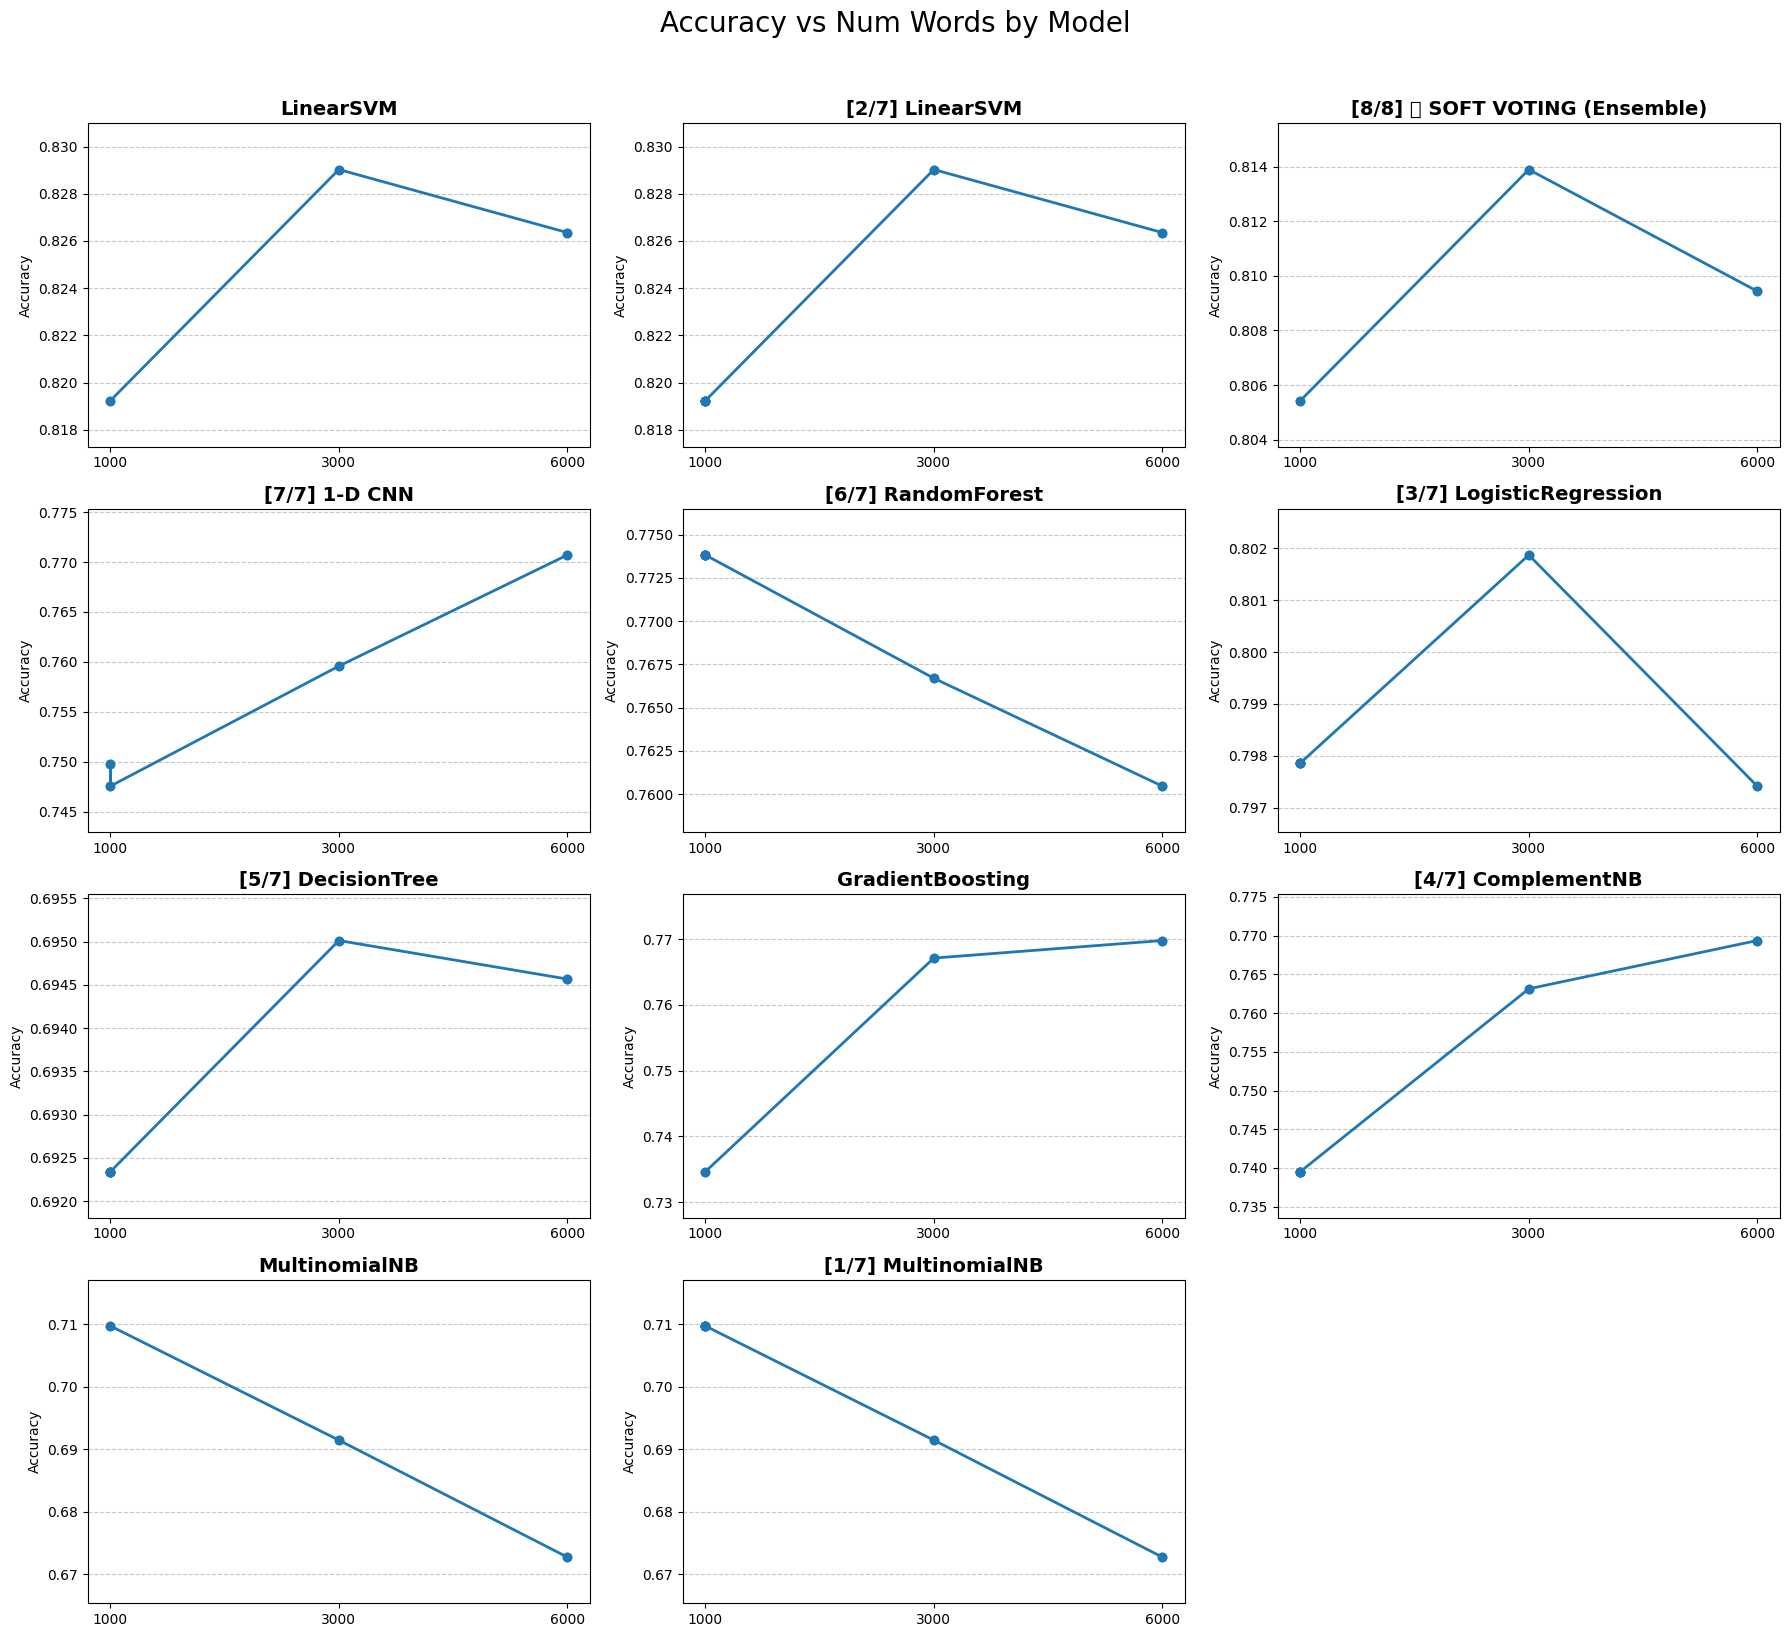

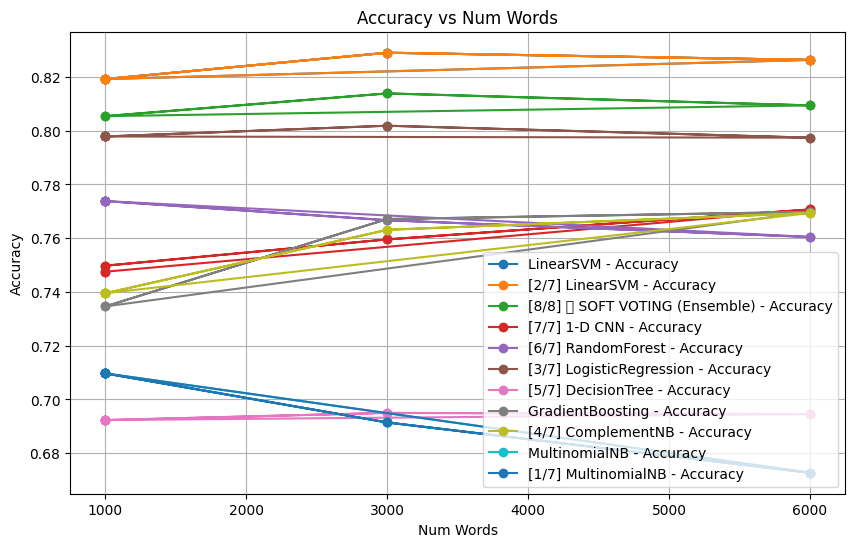

In [ ]:
# Acc
draw_metric_grid(final_df, 'Accuracy', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["Accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# **결과: 최고 성능은 LinearSVM으로 보이며, voca size 3000일때 최고 성능을 보임. Soft voting의 성능이 인상적이며 가능성이 보임.**

/tmp/ipython-input-3353349899.py:49: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


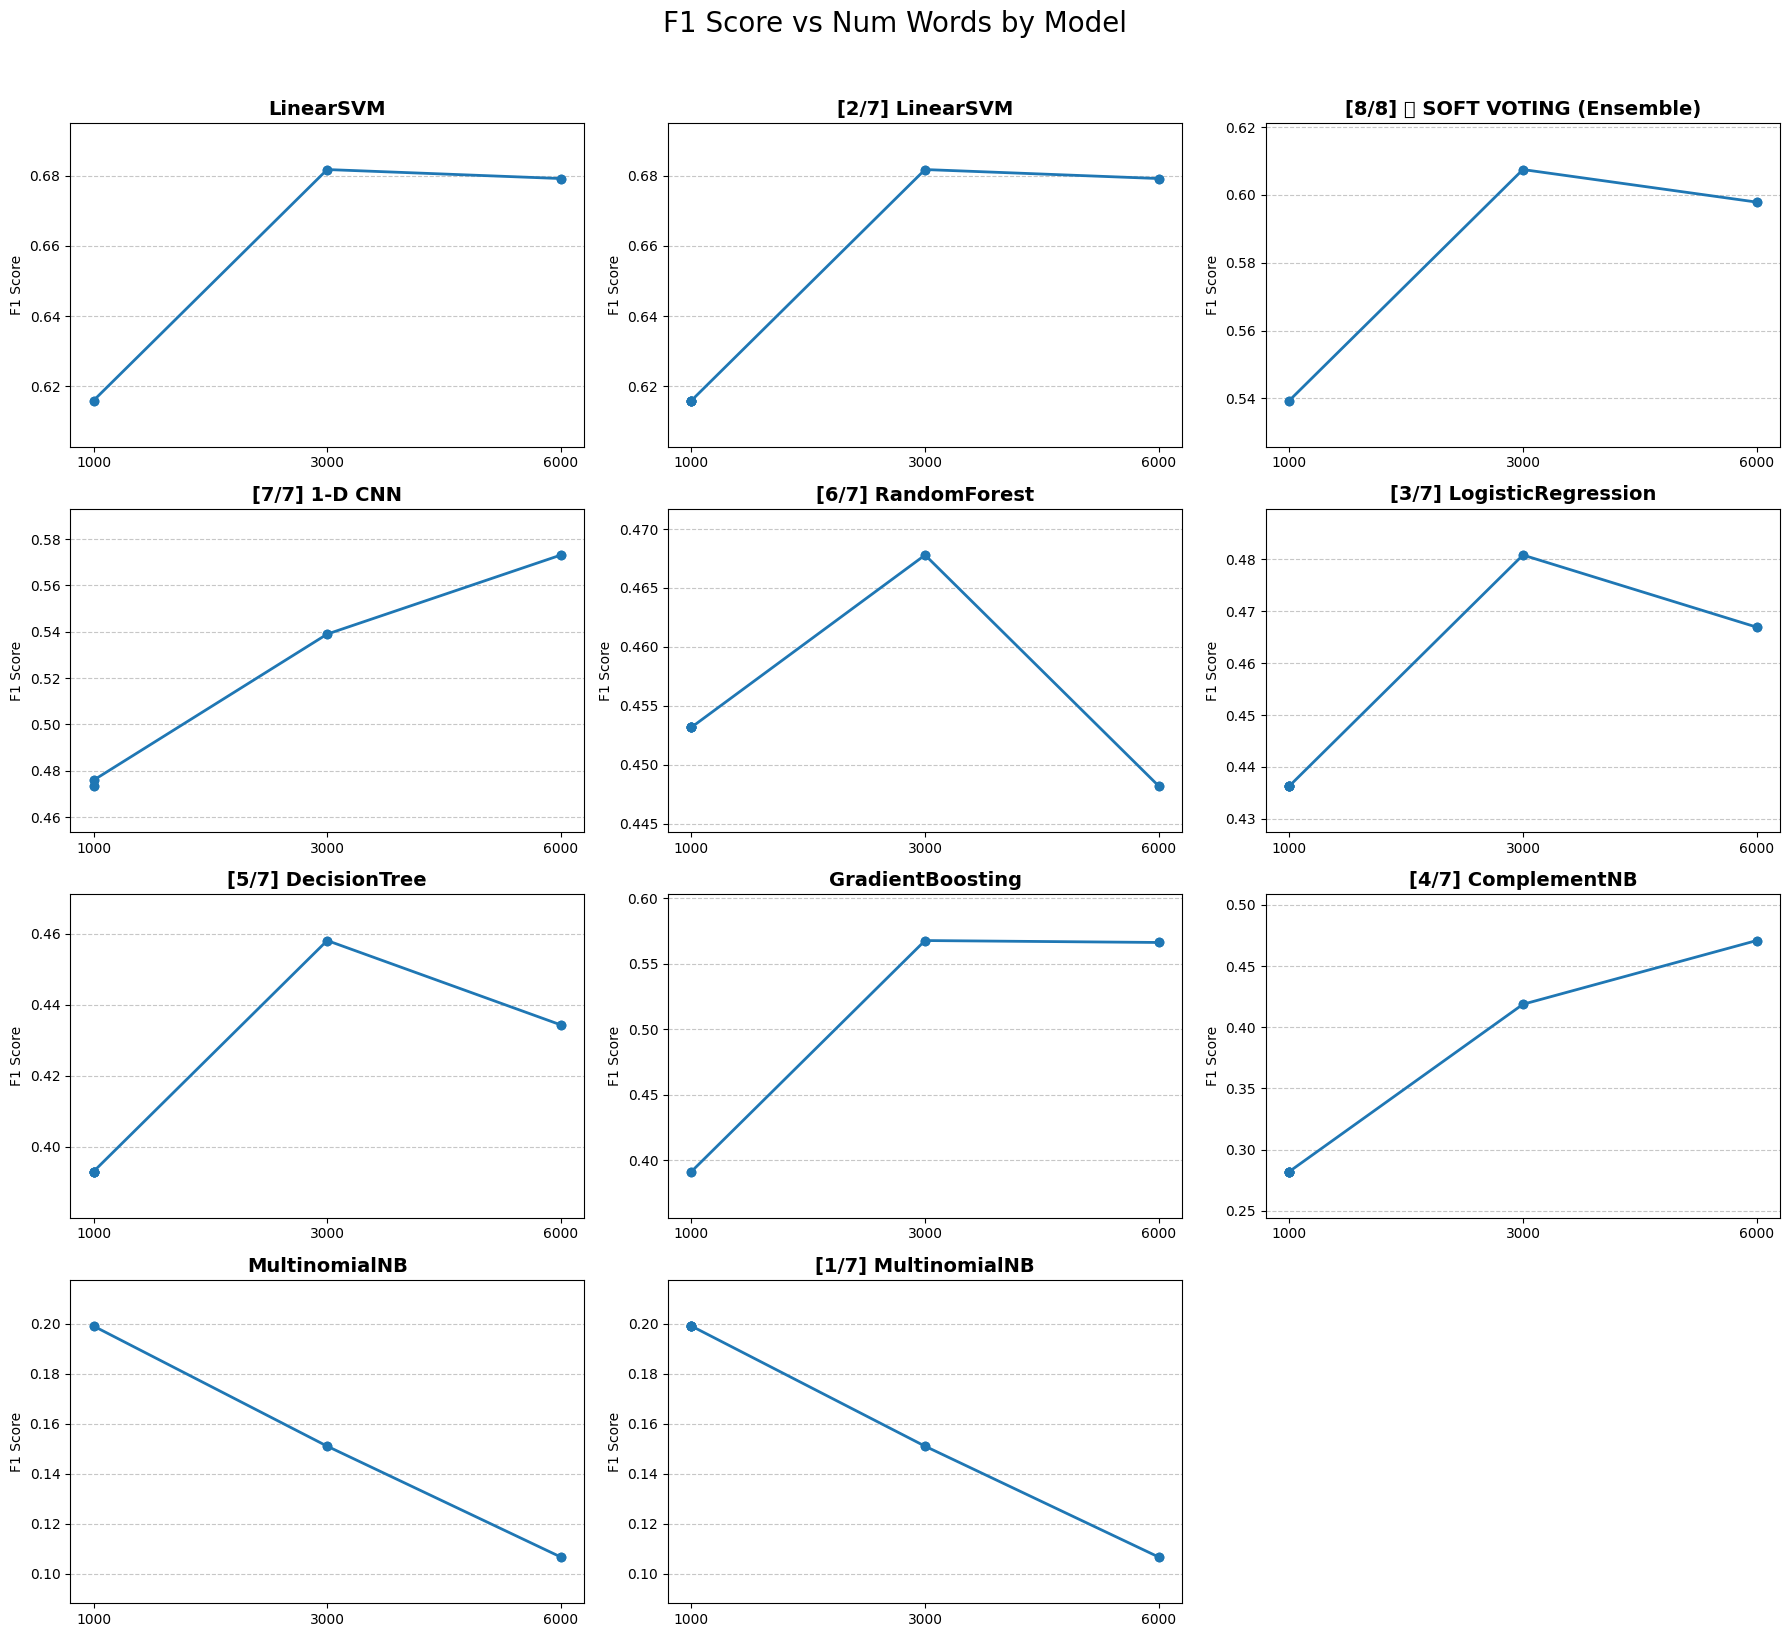

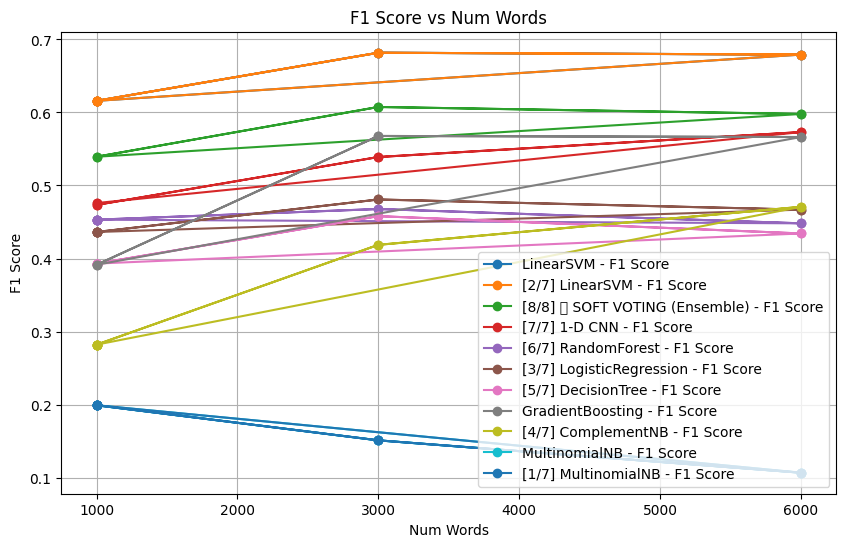

In [ ]:
# F1 score
draw_metric_grid(final_df, 'F1 Score', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["F1 Score"], marker='o', label=f"{model_name} - F1 Score")

plt.title("F1 Score vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# **결과: LinearSVM 가장 높은 성능을 보여준다.**

소회

1) 코딩 연습을 더 해야겠습니다.
2) 모델에 대한 보다 깊숙한 이해를 가져야겠다고 생각됩니다. 누군가에서 설명한다고 해도 아직 모델들을 잘 설명할 수 없을 것 같아요. 부족합니다.